## Build training sets
**!!! First run the Jupyter backend setup** 

https://github.com/xiaohang007/SLICES?tab=readme-ov-file#jupyter-backend-setup

In [ ]:
%matplotlib inline
from invcryrep.utils import temporaryWorkingDirectory,search_materials,exclude_elements_json,splitRun,show_progress,collect_json,collect_csv
import os
# Download entries to build training sets
with temporaryWorkingDirectory("./benchmark/Validity_rate_ucRNN__Success_rate_cRNN/0_get_json/0_get_mp20_json"):
    os.system("python 0_mp20.py")
# Rule out unsupported elements
with temporaryWorkingDirectory("./benchmark/Validity_rate_ucRNN__Success_rate_cRNN/0_get_json/1_element_filter"):
    splitRun(filename='../0_get_mp20_json/cifs.json',threads=16,skip_header=False)
    show_progress()
    collect_json(output="cifs_filtered.json", glob_target="./**/output.json",cleanup=True)
# Convert to primitive cell
with temporaryWorkingDirectory("./benchmark/Validity_rate_ucRNN__Success_rate_cRNN/0_get_json/2_primitive_cell_conversion"):
    splitRun(filename='../1_element_filter/cifs_filtered.json',threads=16,skip_header=False)
    show_progress()
    collect_json(output="cifs_filtered.json", glob_target="./**/output.json",cleanup=True)
# Rule out crystals with low-dimensional units (e.g. molecular crystals or layered crystals)
with temporaryWorkingDirectory("./benchmark/Validity_rate_ucRNN__Success_rate_cRNN/0_get_json/3_3d_filter"):
    splitRun(filename='../2_primitive_cell_conversion/cifs_filtered.json',threads=16,skip_header=False)
    show_progress()
    collect_json(output="../cifs_filtered.json", glob_target="./**/output.json",cleanup=True)

# Convert crystal structures in datasets to SLICES strings and conduct data augmentation
**Set 'augment': 5 to speed up the test run.**

**Set 'augment': 50 to reproduce the results reported in the manuscript**

In [ ]:
from invcryrep.utils import temporaryWorkingDirectory,splitRun,show_progress,collect_json,collect_csv
import configparser
with temporaryWorkingDirectory("./benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/1_augmentation"):
    config = configparser.ConfigParser()
    config["Settings"] = {'augment': 5, 'graph_method':'econnn' }
    with open('./workflow/settings.ini', 'w') as configfile:
        config.write(configfile)
    splitRun(filename='../../0_get_json/cifs_filtered.json',threads=16,skip_header=False)
    show_progress()
    collect_csv(output="./prior_aug.sli", glob_target="./**/result.sli",header="",cleanup=True)

# Train_sample
## Train conditional RNN
**Set --epochs 1 to speed up the test run.**

**To accelerate the training process, consider adjusting the batch_size appropriately.**

**e.g., --batch_size 60 for 4GB GPU memory, --batch_size 360 for 24GB GPU memory**

**Set --epochs 10 to reproduce the results reported in the manuscript**

In [ ]:
from invcryrep.utils import temporaryWorkingDirectory
import os
with temporaryWorkingDirectory("./benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/2_train_sample"):
    os.system("python data_structs.py ../1_augmentation/prior_aug.sli")
    os.system("python train_prior.py --batch_size 60 --epochs 1")

## Sample 1000 SLICES strings with specified $E_{form}$ = -4.5 eV/atom
**Set {'target': -4.5 } as the specified $E_{form}$**

In [ ]:
from invcryrep.utils import temporaryWorkingDirectory,splitRun_sample,show_progress,collect_csv
import configparser
with temporaryWorkingDirectory("./benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/2_train_sample"):
    config = configparser.ConfigParser()
    config["Settings"] = {'target': -4.5 }
    with open('./workflow/settings2.ini', 'w') as configfile:
        config.write(configfile)
    splitRun_sample(threads=10,sample_size=1000) # generate 16000 SLICES in total with 8 CPU threads 
    show_progress()
    collect_csv(output="sampled.sli", glob_target="job_*/100x.sli",header="",cleanup=False)

# Reconstruct crystal structures from SLICES strings (duplicate edges fixed) and calculate the number of reconstructed crystals (num_reconstructed) 

In [ ]:
from invcryrep.utils import temporaryWorkingDirectory,splitRun_csv,show_progress,collect_csv
with temporaryWorkingDirectory("./benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/3_inverse"):
    splitRun_csv(filename='../2_train_sample/sampled.sli',threads=16,skip_header=False)
    show_progress()
    collect_csv(output="results_3_inverse.csv", glob_target="job_*/result.csv",\
                header='SLICES,formula,energy_per_atom,POSCAR\n',cleanup=True)

# Evaluate the formation energy distribution of the reconstructed crystals with the M3GNet model

Computational tasks have been submitted.


     100%|███████████████| 100/100 [00:06<00:00, 15.11it/s] 


Results have been collected into: results_4_eform_m3gnet.csv


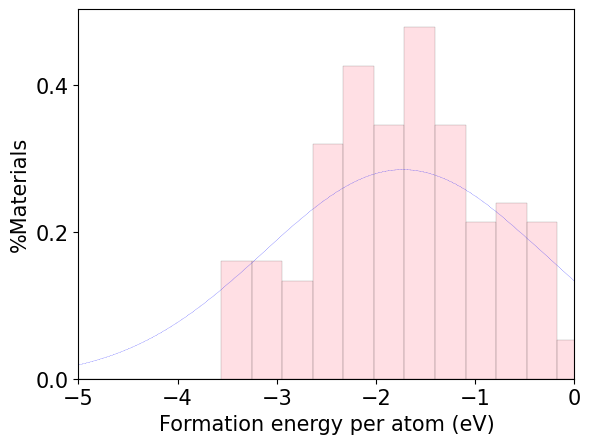

In [4]:
from invcryrep.utils import temporaryWorkingDirectory,splitRun_csv,show_progress,collect_csv,os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
with temporaryWorkingDirectory("./benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/4_eform_m3gnet"):
    splitRun_csv(filename='../3_inverse/results_3_inverse.csv',threads=16,skip_header=True)
    show_progress()
    collect_csv(output="results_4_eform_m3gnet.csv", glob_target="job_*/result.csv",\
                header='index,SCILES,POSCAR,formula,energy_per_atom,eform\n',index=True,cleanup=True)
    # plot the formation energy distribution (PBE) of the reconstructed crystals 
    #os.system("python 3_normal_distri_plot.py")
    plt.rcParams.update({'font.size': 15}) 
    with open("results_4_eform_m3gnet.csv") as f:
        data = [float(line.strip().split(',')[-1]) for line in f if line.strip().split(',')[-1]!="eform" ]
    props, bins, patches = plt.hist(data, bins=50, density=True, 
                                     edgecolor='black', facecolor='pink',linewidth=0.2, alpha=0.5)
    outputs = [[str(a), str(b)] for a, b in zip(bins[:-1],props)]
    with open('formation_energy.txt','w') as f:
        for op in outputs:
            f.write('\t'.join(op))
            f.write('\n')
    mean = np.mean(data)
    std = np.std(data)
    x = np.linspace(mean - 5*std, mean + 5*std, 200)
    y = np.exp(-((x - mean)**2)/(2*std**2)) / (std * np.sqrt(2*np.pi))
    plt.plot(x, y, linewidth=0.2,linestyle='--',c='b')
    with open('normalized_distribution.txt','w') as f:
        for op in zip(x, y):
            f.write('\t'.join([str(num) for num in op]))
            f.write('\n')
    plt.xlim(-5,0)
    plt.locator_params(axis='x', nbins=5) 
    plt.locator_params(axis='y', nbins=5)     
    plt.xlabel('Formation energy per atom (eV)')
    plt.ylabel('%Materials')  
    plt.savefig('plot.png') 
    plt.show()
    os.system("rm formation_energy.txt normalized_distribution.txt  ")

# Evaluate the formation energy distribution of the reconstructed crystals at PBE level (took less than 1 day to finish with 36*26 cores HPC; need to tweak the ./workflow/0_EnthalpyOfFormation\*.py to deal with some tricky cases of VASP cell optimization)
```bash
cd /crystal/benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/5_eform_PBE
python 1_splitRun.py
#After running python 1_splitRun.py, the computation is only submitted to the queue, 
# not completed. To monitor the progress of the computation, use the qstat command. 
#If all tasks are marked with a status of "C", it indicates that the computation has finished.
python 2_collect_clean_glob_details.py
#After the computation are finished, running python 2_collect_clean_glob_details.py to get results.
python 3_normal_distri_plot.py # plot the formation energy distribution (PBE) of the reconstructed crystals 
```
# **Reproduction of Table 3:**  Calculate SR5, SR10, SR15 in Table S1 using formation energies (at PBE level) of crystals generated with a target of -4.5 eV/atom
```bash
cd /crystal/benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/6_calculate_FigureS2c
python calculate_SR5-10-15_TableS1.py # SR5, SR10, SR15 are printed in the terminal
```

# **Reproduction of Fig. S2c:** Repeat step (3-6) with $E_{form}$ target = -3.0, -4.0, -5.0, -6.0 eV/atom. Extract formation energy distributions from "results_5_eform_m3gnet.csv" in step (6) and transfer the data to "/crystal/benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/6_calculate_FigureS2c/energy_formation_m3gnet_lists.csv". Then:
```bash
cd /crystal/benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/6_calculate_FigureS2c
python plot_FigureS1c.py # get Fig. S2c as test3.svg
```
The formation energy distributions with $E_{form}$ target = -3.0, -4.0, -5.0, -6.0 eV/atom can be accessed from "/crystal/benchmark/Validity_rate_ucRNN__Success_rate_cRNN/2_conditioned_RNN/Other_targets/3_eform_\*".